# Milstein Lab Summer Research Tutorial 6 - Incorporating a mossy cell-like excitatory feedback population 

# Main question: How can a network of neurons generate a unique pattern of output for every distinct combination of its inputs?

### We are building a simple neuronal network model loosely inspired by the structure of the dentate gyrus region of the hippocampus. 

<img src="images/dentate_intro_slide.jpg" width="1000">

## Outline:

Last week we updated our temporally dynamic network to include a dedicated feedback inhibitory cell population. Today we will review our methods for generating, exporting, importing, plotting, and comparing models with different configurations with temporal dynamics. Then we will add a new neuronal cell population that will be dedicated to feedback excitation, similar to dentate mossy cells.
<br>
1. Review challenge from last week:
 - Compare sparsity and discriminability in networks with only FF vs. both FF and FB inhibition.
2. Update our temporally dynamic network to incorporate mossy cell-like dedicated feedback excitation.

## Challenge for next week:
 - Calibrate excitatory feedback connections from mossy cells to further improve sparsity and discriminability.

## 1. Review challenge from last week:

### Compare sparsity and discriminability in networks with only FF vs. both FF and FB inhibition.
 - Iterate over all input patterns.
 - Just analyze the last time point (after temporal dynamics have equilibrated).

### Let's move to PyCharm and look at the script: tutorial6_simulate_model.py

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from tutorial6_simulate_dynamic_model import get_binary_input_patterns, get_callable_from_str, piecewise_linear_activation, \
    identity_activation, get_weight_dict, get_network_dynamics_dicts, slice_network_activity_dynamics_dict, \
    analyze_sparsity_and_similarity, analyze_sparsity_and_similarity_dynamics, plot_model_summary, plot_sparsity_and_similarity_dynamics

Let's build a network and initialize our intermediate dictionaries so we can test that these functions work:

/Users/ag1880/Github_repos/summer_2021/tutorial6_simulate_dynamic_model.py:883: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


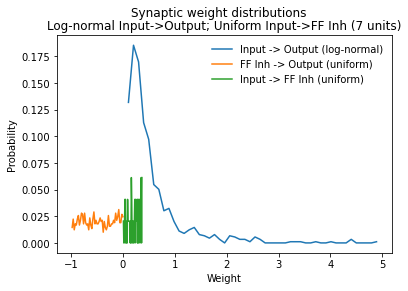

In [2]:
seed = 1234
description = 'Log-normal Input->Output; Uniform Input->FF Inh (7 units)'
num_input_units = 7
output_activation_function = 'piecewise_linear_activation'
output_input_weight_dist_type = 'log-normal'
output_input_mean_weight_magnitude = 0.5

num_FF_inh_units = 7
FF_inh_activation_function = 'identity_activation'
FF_inh_input_weight_dist_type = 'uniform'
FF_inh_input_mean_weight_magnitude = 0.2
output_FF_inh_weight_dist_type = 'uniform'
output_FF_inh_mean_weight_magnitude = 0.5

sorted_input_patterns = get_binary_input_patterns(num_input_units, sort=True)

# Specify the shape of the network (i.e. how many input/output/inhibitory neurons):
num_units_dict = {'Input': num_input_units,
                  'Output': len(sorted_input_patterns)}

# Let's be explicit about whether we will apply a nonlinear activation function to each population:
activation_function_dict = {'Output': get_callable_from_str(output_activation_function)}

weight_config_dict = {'Output':
                          {'Input': {'dist_type': output_input_weight_dist_type,
                                     'mean_magnitude': output_input_mean_weight_magnitude,
                                     'connection_type': 'exc'}}}

if num_FF_inh_units > 0:
    num_units_dict['FF Inh'] = num_FF_inh_units
    activation_function_dict['FF Inh'] = get_callable_from_str(FF_inh_activation_function)
    weight_config_dict['FF Inh'] = {'Input':
                                        {'dist_type': FF_inh_input_weight_dist_type,
                                         'mean_magnitude': FF_inh_input_mean_weight_magnitude,
                                         'connection_type': 'exc'}}
    weight_config_dict['Output']['FF Inh'] = {'dist_type': output_FF_inh_weight_dist_type,
                                              'mean_magnitude': output_FF_inh_mean_weight_magnitude,
                                              'connection_type': 'inh'}

weight_dict = get_weight_dict(num_units_dict, weight_config_dict, seed, description=description, plot=True)

In [3]:
cell_tau_dict = {'Output': 0.05, 'FF Inh': 0.02}
synapse_tau_dict = {'Output': {'Input': 0.01,
                               'FF Inh': 0.02},
                    'FF Inh': {'Input': 0.01}
                   }

duration = 0.2  # seconds
dt = 0.001
t = np.arange(0., duration + dt / 2., dt)

syn_current_dynamics_dict, net_current_dynamics_dict, cell_voltage_dynamics_dict, network_activity_dynamics_dict = \
    get_network_dynamics_dicts(t, sorted_input_patterns, num_units_dict, synapse_tau_dict, cell_tau_dict, weight_dict,
                               activation_function_dict)

This `network_activity_dynamics_dict` now contains data for all input patterns, cells, and time points:

In [4]:
network_activity_dynamics_dict['Output'].shape

(128, 128, 201)

We can extract the activities for just a single time point at the end of each simulation:

In [5]:
final_network_activity_dict = slice_network_activity_dynamics_dict(network_activity_dynamics_dict, t, time_point=duration)

This contains data for all input patterns and cells in a population, but at only one time point:

In [6]:
final_network_activity_dict['Output'].shape

(128, 128)

I updated the similarity matrix to exclude response patterns where all units in a population had zero activity:

In [7]:
summed_network_activity_dict, similarity_matrix_dict = analyze_sparsity_and_similarity(final_network_activity_dict)

/Users/ag1880/Github_repos/summer_2021/tutorial6_simulate_dynamic_model.py:665: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


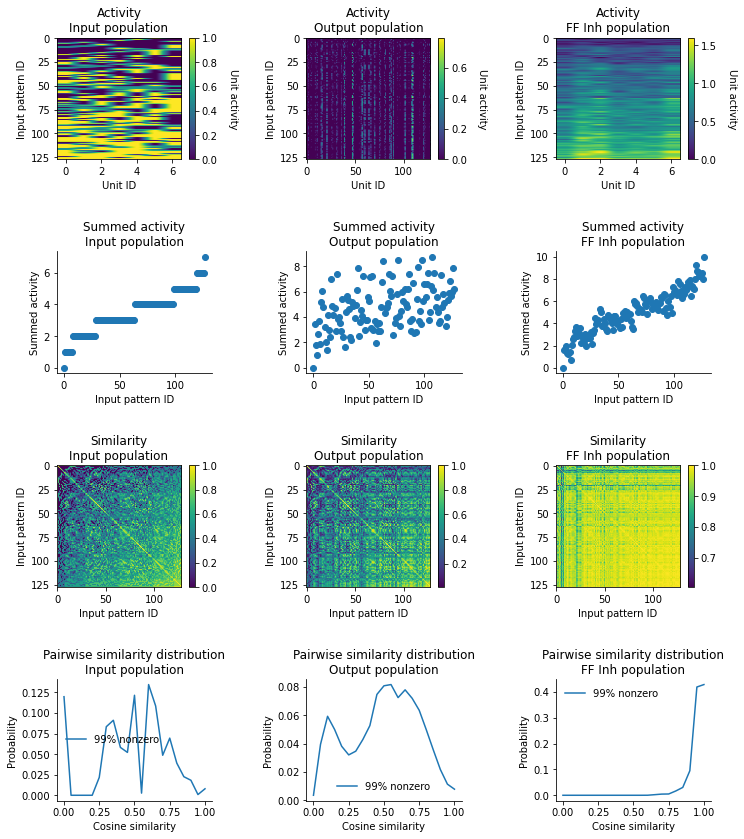

In [8]:
plot_model_summary(final_network_activity_dict, summed_network_activity_dict, similarity_matrix_dict)

Now we can also analyze sparsity and discriminability as they evolve over time instead:

In [9]:
median_summed_network_activity_dynamics_dict, median_similarity_dynamics_dict, fraction_nonzero_response_dynamics_dict = \
    analyze_sparsity_and_similarity_dynamics(network_activity_dynamics_dict)

/Users/ag1880/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/ag1880/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


/Users/ag1880/Github_repos/summer_2021/tutorial6_simulate_dynamic_model.py:759: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


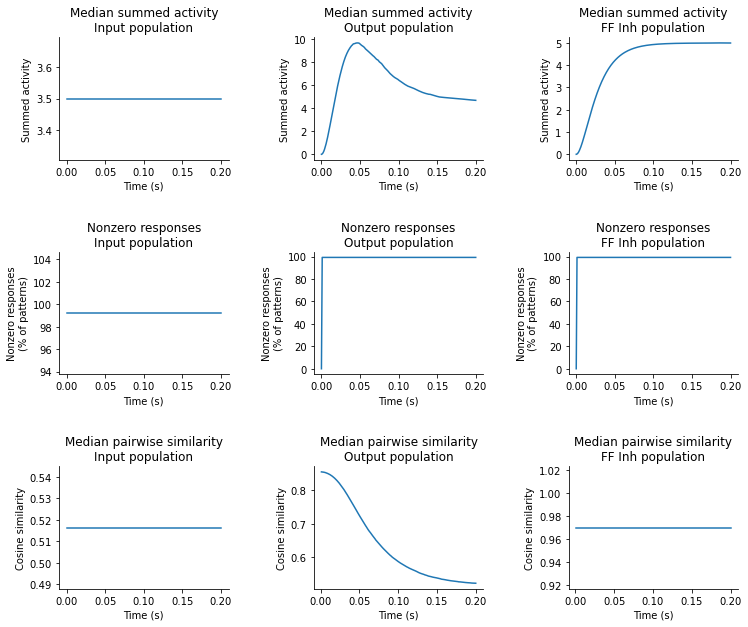

In [10]:
plot_sparsity_and_similarity_dynamics(t, median_summed_network_activity_dynamics_dict, median_similarity_dynamics_dict,
                                              fraction_nonzero_response_dynamics_dict)

I also used the command line interface to generate and export to file data from the following model configurations:

`
python tutorial6_simulate_dynamic_model.py --plot --num_FF_inh_units=0 --num_FB_inh_units=0 --output_FF_inh_mean_weight_magnitude=0.4 --FF_inh_input_mean_weight_magnitude=0.25 --output_FB_inh_mean_weight_magnitude=0.3 --FB_inh_output_mean_weight_magnitude=1. --seed=3 --export --description='No Inh' --export_file_name=20210712_234522_exported_model_data.hdf5
`<br><br>
`
python tutorial6_simulate_dynamic_model.py --plot --num_FF_inh_units=7 --num_FB_inh_units=0 --output_FF_inh_mean_weight_magnitude=0.4 --FF_inh_input_mean_weight_magnitude=0.25 --output_FB_inh_mean_weight_magnitude=0.3 --FB_inh_output_mean_weight_magnitude=1. --seed=1 --export --description='FF Inh only' --export_file_name=20210712_234522_exported_model_data.hdf5
`<br><br>
`
python tutorial6_simulate_dynamic_model.py --plot --num_FF_inh_units=0 --num_FB_inh_units=7 --output_FF_inh_mean_weight_magnitude=0.4 --FF_inh_input_mean_weight_magnitude=0.25 --output_FB_inh_mean_weight_magnitude=0.3 --FB_inh_output_mean_weight_magnitude=1. --seed=4 --export --description='FB Inh only' --export_file_name=20210712_234522_exported_model_data.hdf5
`<br><br>
`
python tutorial6_simulate_dynamic_model.py --plot --num_FF_inh_units=7 --num_FB_inh_units=7 --output_FF_inh_mean_weight_magnitude=0.4 --FF_inh_input_mean_weight_magnitude=0.25 --output_FB_inh_mean_weight_magnitude=0.3 --FB_inh_output_mean_weight_magnitude=1. --seed=2 --export --description='FF and FB Inh' --export_file_name=20210712_234522_exported_model_data.hdf5
`

We can import data from these conditions and generate plots to compare them:

In [11]:
from tutorial6_simulate_dynamic_model import import_dynamic_model_data

In [12]:
data_file_path = 'data/20210712_234522_exported_model_data.hdf5'

model_config_history_dict, num_units_history_dict, activation_function_history_dict, \
           weight_config_history_dict, weight_history_dict, cell_tau_history_dict, synapse_tau_history_dict, \
           syn_current_dynamics_history_dict, net_current_dynamics_history_dict, cell_voltage_dynamics_history_dict, \
           network_activity_dynamics_history_dict, t_history_dict = \
                          import_dynamic_model_data(data_file_path, 'all')

OSError: Unable to open file (unable to open file: name = 'data/20210712_234522_exported_model_data.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

We can recreate the time array from any one of the model configurations:

In [ ]:
t = next(iter(t_history_dict.values()))
duration = t[-1]

We can take a single snapshot of the network activity at the end of the simulation for each of the model configurations:

In [ ]:
network_activity_history_dict = {}
for description in network_activity_dynamics_history_dict:
    network_activity_history_dict[description] = \
        slice_network_activity_dynamics_dict(network_activity_dynamics_history_dict[description], t, time_point=duration)

We can analyze sparsity and similarity from these snapshots and plot each model configuration separately:

In [ ]:
summed_network_activity_history_dict = {}
similarity_matrix_history_dict = {}
for description in network_activity_history_dict:
    summed_network_activity_history_dict[description], similarity_matrix_history_dict[description] = \
        analyze_sparsity_and_similarity(network_activity_history_dict[description])

description = 'FF and FB Inh'
plot_model_summary(network_activity_history_dict[description], summed_network_activity_history_dict[description], \
                       similarity_matrix_history_dict[description], description)

We can also plot the dynamics of summed activity and similarity over time (as a median across all input patterns):

In [ ]:
median_summed_network_activity_dynamics_history_dict = {}
median_similarity_dynamics_history_dict = {}
fraction_nonzero_response_dynamics_history_dict = {}

for description in network_activity_dynamics_history_dict:
    median_summed_network_activity_dynamics_history_dict[description], median_similarity_dynamics_history_dict[description], \
    fraction_nonzero_response_dynamics_history_dict[description] = \
        analyze_sparsity_and_similarity_dynamics(network_activity_dynamics_history_dict[description])

description = 'FF and FB Inh'
plot_sparsity_and_similarity_dynamics(t, median_summed_network_activity_dynamics_history_dict[description], \
                                          median_similarity_dynamics_history_dict[description], 
                                          fraction_nonzero_response_dynamics_history_dict[description], description)

But really we want to generate plots that compare these conditions by superimposing them:

In [ ]:
from tutorial6_simulate_dynamic_model import plot_compare_sparsity_and_similarity_dynamics, plot_compare_model_sparsity_and_similarity

In [ ]:
plot_compare_sparsity_and_similarity_dynamics(t, median_summed_network_activity_dynamics_history_dict,
                                                  median_similarity_dynamics_history_dict,
                                                  fraction_nonzero_response_dynamics_history_dict)

In [ ]:
plot_compare_model_sparsity_and_similarity(summed_network_activity_history_dict, similarity_matrix_history_dict)

From the previous plots, it appeared that when we inclde FB inhibition the similarity is actually lowest around the middle of the timeseries (i.e. around 0.1s). Let's compare the different models at this earlier time point.

In [ ]:
network_activity_history_dict = {}
for description in network_activity_dynamics_history_dict:
    network_activity_history_dict[description] = \
        slice_network_activity_dynamics_dict(network_activity_dynamics_history_dict[description], t, time_point=0.1)
    
summed_network_activity_history_dict = {}
similarity_matrix_history_dict = {}
for description in network_activity_history_dict:
    summed_network_activity_history_dict[description], similarity_matrix_history_dict[description] = \
        analyze_sparsity_and_similarity(network_activity_history_dict[description])

description = 'FF and FB Inh'
plot_model_summary(network_activity_history_dict[description], summed_network_activity_history_dict[description], \
                       similarity_matrix_history_dict[description], description)

In [ ]:
plot_compare_model_sparsity_and_similarity(summed_network_activity_history_dict, similarity_matrix_history_dict)

### Adding FB excitation: Mossy cells

The FB inhibition is in a dynamic equilibrium with the output neurons: when output activity increases, FB inhibition follows and thus pushes the output activity back down, thereby driving it's own input down as well. Initially we can see a peak in FB Inh activity before it stabilizes at a lower level.

What happens when include FB excitation (i.e. Mossy cells)?

In [ ]:
# Set up configuration dictionaries for new model

seed = 1234
description = 'Log-normal Input->Output; FF Inh (7 units) + FB Inh (7 units)'
num_input_units = 7
output_activation_function = 'piecewise_linear_activation'
output_input_weight_dist_type = 'log-normal'
output_input_mean_weight_magnitude = 0.5

num_FF_inh_units = 7
FF_inh_activation_function = 'identity_activation'
FF_inh_input_weight_dist_type = 'uniform'
FF_inh_input_mean_weight_magnitude = 0.2
output_FF_inh_weight_dist_type = 'uniform'
output_FF_inh_mean_weight_magnitude = 0.25

num_FB_inh_units = 7
FB_inh_activation_function = 'identity_activation'
FB_inh_output_weight_dist_type = 'uniform'
FB_inh_output_mean_weight_magnitude = 0.
output_FB_inh_weight_dist_type = 'uniform'
output_FB_inh_mean_weight_magnitude = 0.25

# Example 1: no recurrent connections (i.e. like a slower version of FB inhibition)
# num_FB_exc_units = 7
# FB_exc_activation_function = 'identity_activation'
# FB_exc_output_weight_dist_type = 'uniform'
# FB_exc_output_mean_weight_magnitude = 0.5
# FB_exc_recurrent_weight_dist_type = 'uniform'
# FB_exc_recurrent_mean_weight_magnitude = 0.
# FB_inh_FB_exc_weight_dist_type = 'uniform'
# FB_inh_FB_exc_mean_weight_magnitude = 0.1

# Example 2: recurrent connections
num_FB_exc_units = 7
FB_exc_activation_function = 'identity_activation'
FB_exc_output_weight_dist_type = 'uniform'
FB_exc_output_mean_weight_magnitude = 0.4
FB_exc_recurrent_weight_dist_type = 'uniform'
FB_exc_recurrent_mean_weight_magnitude = 0.05
FB_inh_FB_exc_weight_dist_type = 'uniform'
FB_inh_FB_exc_mean_weight_magnitude = 0.1



sorted_input_patterns = get_binary_input_patterns(num_input_units, sort=True)

# Specify the shape of the network (i.e. how many input/output/inhibitory neurons):
num_units_dict = {'Input': num_input_units,
                  'Output': len(sorted_input_patterns)}

# Let's be explicit about whether we will apply a nonlinear activation function to each population:
activation_function_dict = {'Output': get_callable_from_str(output_activation_function)}

weight_config_dict = {'Output':
                          {'Input': {'dist_type': output_input_weight_dist_type,
                                     'mean_magnitude': output_input_mean_weight_magnitude,
                                     'connection_type': 'exc'}}}

if num_FF_inh_units > 0:
    num_units_dict['FF Inh'] = num_FF_inh_units
    activation_function_dict['FF Inh'] = get_callable_from_str(FF_inh_activation_function)
    weight_config_dict['FF Inh'] = {'Input':
                                        {'dist_type': FF_inh_input_weight_dist_type,
                                         'mean_magnitude': FF_inh_input_mean_weight_magnitude,
                                         'connection_type': 'exc'}}
    weight_config_dict['Output']['FF Inh'] = {'dist_type': output_FF_inh_weight_dist_type,
                                              'mean_magnitude': output_FF_inh_mean_weight_magnitude,
                                              'connection_type': 'inh'}

if num_FB_inh_units > 0:
    num_units_dict['FB Inh'] = num_FB_inh_units
    activation_function_dict['FB Inh'] = get_callable_from_str(FB_inh_activation_function)
    weight_config_dict['FB Inh'] = {'Output':
                                        {'dist_type': FB_inh_output_weight_dist_type,
                                         'mean_magnitude': FB_inh_output_mean_weight_magnitude,
                                         'connection_type': 'exc'}}
    weight_config_dict['Output']['FB Inh'] = {'dist_type': output_FB_inh_weight_dist_type,
                                              'mean_magnitude': output_FB_inh_mean_weight_magnitude,
                                              'connection_type': 'inh'}
    
    if num_FB_exc_units > 0:
        num_units_dict['FB exc'] = num_FB_exc_units
        activation_function_dict['FB exc'] = get_callable_from_str(FB_exc_activation_function)
        weight_config_dict['FB exc'] = {'Output':
                                            {'dist_type': FB_exc_output_weight_dist_type,
                                             'mean_magnitude': FB_exc_output_mean_weight_magnitude,
                                             'connection_type': 'exc'}}
        weight_config_dict['FB Inh']['FB exc'] = {'dist_type': FB_inh_FB_exc_weight_dist_type,
                                                  'mean_magnitude': FB_inh_FB_exc_mean_weight_magnitude,
                                                  'connection_type': 'exc'}
        weight_config_dict['FB exc']['FB exc'] = {'dist_type': FB_exc_recurrent_weight_dist_type,
                                                  'mean_magnitude': FB_exc_recurrent_mean_weight_magnitude,
                                                  'connection_type': 'exc'}    
    
    
weight_dict = get_weight_dict(num_units_dict, weight_config_dict, seed, description=description, plot=True)

cell_tau_dict = {'Output': 0.05, 'FF Inh': 0.02, 'FB Inh': 0.02, 'FB exc': 0.02}
synapse_tau_dict = {'Output': {'Input': 0.01, 
                               'FF Inh': 0.02, 
                               'FB Inh': 0.02},
                    'FF Inh': {'Input': 0.01},
                    'FB Inh': {'Output': 0.01,
                               'FB exc': 0.01},
                    'FB exc': {'Output': 0.01,
                               'FB exc': 0.01}
                   }

In [ ]:
# Run simulation and store values in dictionaries
duration = 0.2
dt = 0.001
time_point = 0.2

t = np.arange(0., duration + dt / 2., dt)

syn_current_dynamics_dict, net_current_dynamics_dict, cell_voltage_dynamics_dict, network_activity_dynamics_dict = \
    get_network_dynamics_dicts(t, sorted_input_patterns, num_units_dict, synapse_tau_dict, cell_tau_dict,
                               weight_dict, activation_function_dict)

network_activity_dict = slice_network_activity_dynamics_dict(network_activity_dynamics_dict, t,
                                                             time_point=time_point)

summed_network_activity_dict, similarity_matrix_dict = analyze_sparsity_and_similarity(network_activity_dict)

median_summed_network_activity_dynamics_dict, median_similarity_dynamics_dict, \
fraction_nonzero_response_dynamics_dict = analyze_sparsity_and_similarity_dynamics(network_activity_dynamics_dict)

In [ ]:
%matplotlib inline
plot_model_summary(network_activity_dict, summed_network_activity_dict, similarity_matrix_dict, description)

In [ ]:
plot_sparsity_and_similarity_dynamics(t, median_summed_network_activity_dynamics_dict,
                                      median_similarity_dynamics_dict, fraction_nonzero_response_dynamics_dict,
                                      description)

## Challenge for next week:
### Calibrate excitatory feedback connections from mossy cells to further improve sparsity and discriminability.
 - Include Output->FB Exc connections.
 - Replace Output->FB Inh connections with FB Exc->FB Inh connections.
 - Include recurrent FB Exc->FB Exc connections.